In [2]:
import pandas as pd
import numpy as np
import os
from options import *
import cv2
import torch
import matplotlib.pyplot as plt
import dlib


video_path = "./dataset/train/training80_01/_uNup91ZYw0.002.mp4"
video = cv2.VideoCapture(video_path)

if not video.isOpened():
    print("打开视频{}失败！".format(video_path))
total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)

In [3]:
index = torch.rand(6)
per = total_frames // 6
print(index,per)
for i in range(6):
    index[i] = index[i]*per + i*per
index = index.to(dtype=torch.int)
index

tensor([0.5248, 0.9117, 0.1807, 0.3017, 0.5686, 0.0553]) 61.0


tensor([ 32, 116, 133, 201, 278, 308], dtype=torch.int32)

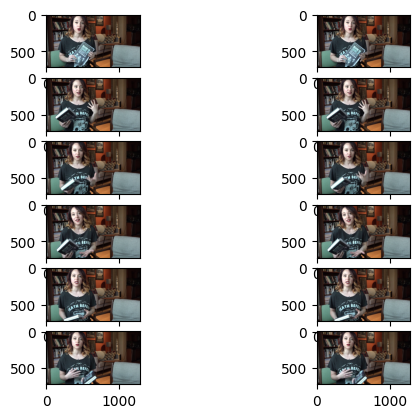

(6, 2, 720, 1280, 3)

In [4]:
frames_list = np.zeros((6, 2, 720, 1280, 3), dtype=np.uint8)
for i, ind in enumerate(index):
    if ind == 0:
        ind =1
    video.set(cv2.CAP_PROP_POS_FRAMES, float(ind))
    _, cur = video.read()
    plt.subplot(6, 2, 2*i+1)
    plt.imshow(cv2.cvtColor(cur, cv2.COLOR_BGR2RGB))
    frames_list[i, 0] = cur
    video.set(cv2.CAP_PROP_POS_FRAMES, float(ind-1))
    _, pre = video.read()
    plt.subplot(6, 2, 2*i+2)
    plt.imshow(cv2.cvtColor(pre, cv2.COLOR_BGR2RGB))
    frames_list[i,1] = pre
plt.show()
frames_list.shape

获取光流信息

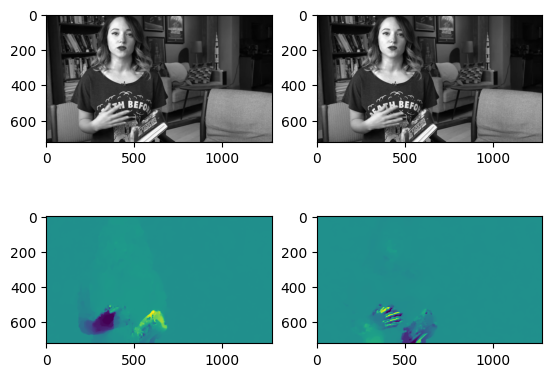

(6, 720, 1280, 2)

In [5]:
def compute_TVL1(prev, curr, bound=15):
    TVL1 = cv2.optflow.DualTVL1OpticalFlow_create()
    flow = TVL1.calc(prev, curr, None)

    assert flow.dtype == np.float32

    flow = (flow + bound) * (255.0 / (2 * bound))
    flow = np.round(flow).astype(int)
    flow[flow >= 255] = 255
    flow[flow <= 0] = 0

    return flow
flows_list = np.zeros((len(frames_list), 720, 1280, 2), dtype=np.uint8)
for i, frames in enumerate(frames_list):
    cur = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    pre = cv2.cvtColor(frames[1], cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(cur, cv2.COLOR_BGR2RGB))
    plt.subplot(2, 2 ,2)
    plt.imshow(cv2.cvtColor(pre, cv2.COLOR_BGR2RGB))
    flow = compute_TVL1(pre, cur)
    flows_list[i] = flow
    plt.subplot(2, 2, 3)
    plt.imshow(flow[:,:,0])
    plt.subplot(2, 2, 4)
    plt.imshow(flow[:,:,1])
plt.show()
flows_list.shape

获取人脸区域

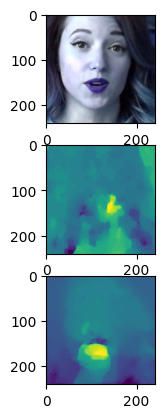

In [6]:
def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

def get_image_face(frames_list, flows_list):
    cropped_face_rgb = []*6
    cropped_face_flow = []*6
    face_detector = dlib.get_frontal_face_detector()
    height, width = frames_list.shape[2:4]
    # frame_transform = transforms.Compose([
    #         transforms.ToTensor(),
    #         transforms.Resize([224, 224]),
    #         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    #     ])
    # flow_transform = transforms.Compose([
    #         transforms.ToTensor(),
    #         transforms.Resize([224, 224]),
    #     ])
    
    for i, frame in enumerate(frames_list):
        gray = cv2.cvtColor(frame[0], cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 1)
        if len(faces):
            # For now only take biggest face
            face = faces[0]

            # --- Prediction ---------------------------------------------------
            # Face crop with dlib and bounding box scale enlargement
            x, y, size = get_boundingbox(face, width, height)
            cropped_face_rgb.append(frame[0][y:y+size, x:x+size, :])
            cropped_face_flow.append(flows_list[i][y:y+size, x:x+size, :])
    return cropped_face_rgb, cropped_face_flow
    
cropped_face_rgb, cropped_face_flow = get_image_face(frames_list=frames_list,
                                                            flows_list=flows_list)
# print(cropped_face_rgb.shape, cropped_face_flow.shape)
cropped_face_rgb, cropped_face_flow = np.array(cropped_face_rgb), np.array(
    cropped_face_flow
)
cropped_face_flow.shape, cropped_face_rgb.shape
plt.subplot(3, 1, 1)
plt.imshow(cropped_face_rgb[0])
plt.subplot(3, 1, 2)
plt.imshow(cropped_face_flow[0][:, :, 0])
plt.subplot(3, 1, 3)
plt.imshow(cropped_face_flow[0][:, :, 1])
plt.show()

In [6]:
from model import network
import torch.nn as nn

try:
    model = network.func_dict['resnet18']
except:
    print("model:{} isn't existed".format('resnet18'))
instance = model(pretrained=True, progress=True)
in_features = instance.fc.in_features
instance.fc = nn.Linear(in_features=in_features, out_features=240)


In [7]:
input = torch.rand((128, 6, 3, 224, 224))
for i in range(6):
    feat1 = instance(input[:, i, ...].squeeze(1))
    if i == 0:
        vid_feat = feat1.unsqueeze(1)
    else:
        vid_feat = torch.cat((vid_feat, feat1.unsqueeze(1)), dim=1)
vid_feat.shape, vid_feat

(torch.Size([128, 6, 240]),
 tensor([[[ 1.2369e+00,  6.1747e-01, -1.6387e-01,  ..., -2.1827e-01,
            6.9657e-01, -1.0984e+00],
          [ 3.6973e-01,  5.9293e-02,  2.8142e-01,  ..., -1.5392e-01,
            4.0844e-02, -1.9250e+00],
          [ 8.2825e-01, -1.3629e-01, -2.1219e-01,  ...,  9.0246e-02,
            8.3502e-01, -1.3401e+00],
          [ 4.4926e-01,  5.0620e-01,  1.0484e-01,  ..., -4.2493e-01,
            5.0394e-01, -7.4100e-01],
          [ 5.6714e-01,  2.3826e-01, -1.6248e-01,  ..., -9.3171e-02,
            3.5370e-01, -1.2596e+00],
          [ 5.9435e-01,  5.2769e-01, -3.4040e-01,  ..., -1.1563e-01,
            3.7953e-01, -7.2972e-01]],
 
         [[ 4.9562e-01,  5.1003e-01,  2.6470e-01,  ...,  1.3213e-01,
            3.7705e-01, -8.4387e-01],
          [ 4.7369e-01,  2.1785e-01, -8.5436e-02,  ..., -6.9895e-01,
            1.1191e+00, -1.0836e+00],
          [ 2.7709e-01,  3.7333e-01, -3.3198e-01,  ..., -4.6825e-01,
            1.0031e+00, -8.7660e-01],
      

In [8]:
input = input.reshape(128*6, 3, 224, 224)
vid_feat = instance(input)
vid_feat = vid_feat.reshape(128, 6, 240)
vid_feat.shape, vid_feat

(torch.Size([128, 6, 240]),
 tensor([[[ 1.2297,  0.6802, -0.2459,  ..., -0.2150,  0.6665, -1.1153],
          [ 0.3827,  0.0237,  0.2888,  ..., -0.1596,  0.0412, -1.9859],
          [ 0.8291, -0.1681, -0.0783,  ...,  0.1340,  0.8389, -1.3148],
          [ 0.4292,  0.5461,  0.0399,  ..., -0.4101,  0.4891, -0.7339],
          [ 0.5721,  0.1615, -0.1152,  ..., -0.0634,  0.3115, -1.2794],
          [ 0.6434,  0.5379, -0.3611,  ..., -0.0900,  0.4284, -0.7133]],
 
         [[ 0.4957,  0.5549,  0.1936,  ...,  0.1361,  0.3331, -0.8432],
          [ 0.5150,  0.2059, -0.0784,  ..., -0.7857,  1.1363, -1.1729],
          [ 0.2755,  0.3447, -0.1969,  ..., -0.4624,  0.9986, -0.8301],
          [ 0.6814,  0.5067, -0.0609,  ..., -0.2198,  0.7502, -1.1978],
          [ 0.5824, -0.2481, -0.2887,  ...,  0.4758,  0.4105, -1.0588],
          [ 0.8134,  0.5733,  0.2902,  ..., -0.0125,  0.7118, -1.6705]],
 
         [[ 0.8438,  0.4991, -0.0232,  ..., -0.1841,  0.6728, -1.2482],
          [ 0.0690,  0.3748, -